# Optimal Growth — Course Notebook

**Goals**
1. Load the `OptimalGrowth` package (local `.py` module).
2. Simulate a baseline economy.
3. Compute and *display* the planner's **effective optimization window**.
4. Provide **exercises** with empty cells for students to complete.
5. Run **sensitivity analyses** (parameters **and** the planner's window size).

> This notebook is self‑contained and uses the local file `OptimalGrowth.py` provided with the course materials.

## 1) Setup & Imports

In [1]:
# If you run this notebook elsewhere, adapt the path so it can find OptimalGrowth.py
import sys, os, importlib, math
from pathlib import Path
import OptimalGrowth  as og


## 2) Model Parameters (`Params`)

In [3]:
# Inspect default parameters
p = og.Params()
print(p)
print("\nNumber of periods nT =", p.nT, "with step Δ =", p.Delta, "years")
print("Time runs from", p.t0, "to", p.tT)

Params(Delta=1, t0=1, tT=100, nT=100, alpha=0.3, A0=1.0, gA=0.0, deltaA=0.005, L0=1.0, Linf=10500, lg=0.0, delta=0.06, K0=3.0, rho=0.015, gamma=2.0, tolx=1e-12, toly=0.001)

Number of periods nT = 100 with step Δ = 1 years
Time runs from 1 to 100


## 3) Initialize state and determine exogenous path

Before solving the planner’s problem, we need to **set the environment of the economy**.  
This involves two steps:

1. **Exogenous variables** — external drivers such as productivity and population, which follow paths we specify in advance.  
2. **Initial state variables** — endogenous stocks like capital, which determine where the economy starts from.

We begin with the exogenous variables.

### Setting exogenous states

Exogenous state variables are given by $x_t \in \mathbb{R}^{N_x}$: productivity $A_t$, population $L_t$.

They follow an exogenous process:
$$
x_t = g(x_{t-1}), \quad g: \mathbb{R}^{N_x} \to \mathbb{R}^{N_x}.
$$


In this simplified notebook, we use two exogenous variables, $$A_t=L_t=1$$ that we have **fixed both to 1** (flat paths) to isolate the core mechanics.  
We store these in the $y$ matrix later; other variables are left as `NaN` until solved.

### Setting initial state variables
We also initialize state variables.



In [5]:
# Initialize the simulation matrix with exogenous drivers and initial states
sim = og.init_states(p)

# Convert to a tidy DataFrame for inspection (optional)
df0 = og.mat_to_df(sim, p)
df0.head()

,time,K,Y,I,C,s,A,L
0,1.0,3.0,NaN,NaN,NaN,0.24,1.0,1.0
1,2.0,NaN,NaN,NaN,NaN,0.24,1.0,1.0
2,3.0,NaN,NaN,NaN,NaN,0.24,1.0,1.0
3,4.0,NaN,NaN,NaN,NaN,0.24,1.0,1.0
4,5.0,NaN,NaN,NaN,NaN,0.24,1.0,1.0


## 4) The Planner’s Optimization Problem

We now turn to the **central planner’s problem**.  
The planner chooses a sequence of controls (here the *saving rate* $s_t \in [0,1]$) in order to maximize the intertemporal utility of consumption subject to the laws of motion of the economy.

---

#### Objective function

The planner maximizes **expected discounted utility**:

$$
\max_{\{s_t\}_{t=0}^{T}} \; \sum_{i=0}^{I^{*}} \frac{1}{(1+\rho)^{i }} \cdot L_{t+i} \cdot U(c_{t+i}),
$$

where:
- $\rho$ is the pure rate of time preference,  
- $\Delta$ is the time step (e.g. in years),  
- $I^{*}$ is the effective optimization horizon, determined by the tolerance parameter `toly`,  
- $U(c_t, L_t)$ is period utility, typically of **CRRA form**:
  $$
  U(C_t/L_t) = \frac{(c_t)^{1-\gamma}}{1-\gamma},
  $$
  where $\gamma$ is the coefficient of relative risk aversion.

---

#### Constraints

The planner’s choices must satisfy the **resource constraint** and the **law of motion for capital**:

- **Resource constraint**:
  $$
  Y_t = C_t + I_t,
  $$
  where $Y_t$ is output, $C_t$ consumption, and $I_t$ investment.

- **Capital accumulation**:
  $$
  K_{t+1} = (1 - \delta) K_t + I_t,
  $$
  with depreciation rate $\delta$.

- **Production function**:
  $$
  Y_t = A_t K_t^{\alpha} L_t^{1-\alpha},
  $$
  with productivity $A_t$, capital share $\alpha$, and labor $L_t$.

---

#### Effective optimization window

In practice, the infinite horizon is approximated by a finite **planner’s window** $T_{\text{planner}}$.  
This window is determined endogenously by the condition that discounting eventually drives weights below the tolerance `toly`:

$$
\text{while } \left(\frac{1}{1+\rho}\right)^{t} > \text{toly}, \quad t \mapsto T_{\text{planner}}.
$$

Hence the optimization runs over a truncated horizon, long enough so that future terms beyond $T_{\text{planner}}$ are negligible.

---

**Interpretation**:  
The planner sets the saving rate path $\{s_t\}$ to balance *current consumption* against *future capital accumulation*, taking into account discounting and the horizon defined by the planner’s window.


In [12]:
import numpy as np

# Initialize states and simulate with the planner
sim0 = og.init_states(p)
timevec = np.arange(1, p.nT, dtype=int)  # optimization/evolution index

# Bounds and control variable(s): here saving rate s_t in [0,1]
bounds = (0.0, 1.0)
control_id = [p.i_s]

sim_opt = og.run_optimal_policy(sim.copy(), timevec, p, bounds, control_id)

# Define the (effective) planner window size derived from p.rho, p.Delta, and p.toly (module logic).
def planner_window_size(rho, Delta, toly):
    # Reproduce the loop logic in og.run_optimal_policy:
    #   disc starts at 1 and is multiplied by (1/(1+rho))**Delta until it drops below 'toly'.
    if rho <= -1:
        raise ValueError("rho must be > -1")
    disc = 1.0
    Tplanner = 1
    while disc > toly:
        Tplanner += 1
        disc *= (1.0 / (1.0 + rho)) ** Delta
    return Tplanner

T_planner = planner_window_size(p.rho, p.Delta, p.toly)
print(f"Effective planner window (in periods): {T_planner}")
print(f"Time step Δ = {p.Delta} → window ≈ {T_planner * p.Delta} years")


# Convert to a tidy DataFrame for inspection (optional)
df0 = og.mat_to_df(sim_opt, p)
df0.head()


Optimizing: 100%|██████████| 99/99 [00:04<00:00, 20.33it/s]

Effective planner window (in periods): 465
Time step Δ = 1 → window ≈ 465 years


,time,K,Y,I,C,s,A,L
0,1.0,3.000000,1.390389,0.333693,1.056696,0.240000,1.0,1.0
1,2.0,3.153693,1.411386,0.413952,0.997434,0.293294,1.0,1.0
2,3.0,3.378424,1.440835,0.417568,1.023267,0.289810,1.0,1.0
3,4.0,3.593286,1.467735,0.419102,1.048633,0.285543,1.0,1.0
4,5.0,3.796791,1.492193,0.421792,1.070401,0.282666,1.0,1.0


### 3.a) Plots — Optimal Paths

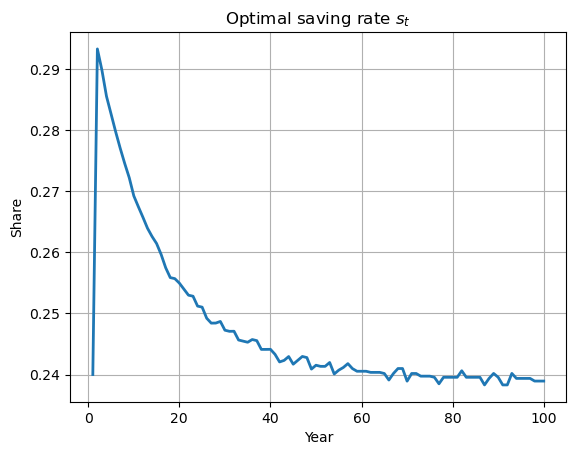

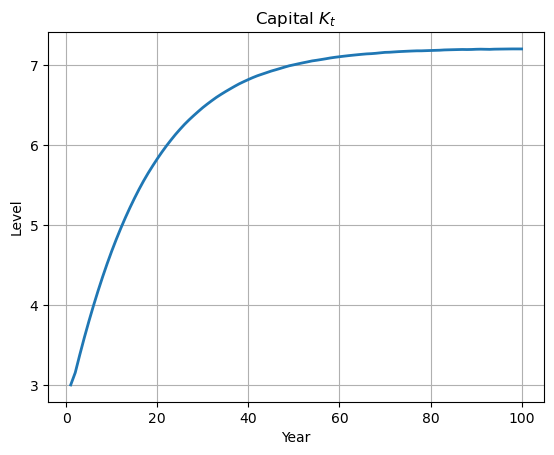

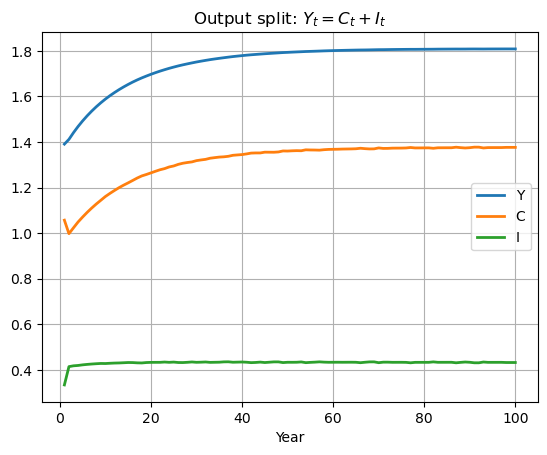

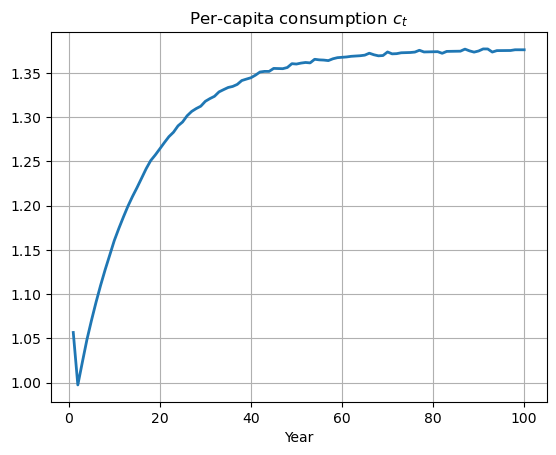

In [10]:
# Charts rule for this course notebook (matplotlib only; one chart per figure)
import matplotlib.pyplot as plt
import numpy as np

years = sim_opt[:, p.i_time]

# s_t
plt.figure()
plt.plot(years, sim_opt[:, p.i_s], linewidth=2)
plt.title("Optimal saving rate $s_t$")
plt.xlabel("Year"); plt.ylabel("Share"); plt.grid(True)
plt.show()

# K_t
plt.figure()
plt.plot(years, sim_opt[:, p.i_K], linewidth=2)
plt.title("Capital $K_t$")
plt.xlabel("Year"); plt.ylabel("Level"); plt.grid(True)
plt.show()

# Y, C, I (three lines in one figure is acceptable; still one plot figure)
plt.figure()
plt.plot(years, sim_opt[:, p.i_Y], linewidth=2, label="Y")
plt.plot(years, sim_opt[:, p.i_C], linewidth=2, label="C")
plt.plot(years, sim_opt[:, p.i_I], linewidth=2, label="I")
plt.title("Output split: $Y_t = C_t + I_t$")
plt.xlabel("Year"); plt.grid(True); plt.legend()
plt.show()

# c_t per capita
plt.figure()
c = sim_opt[:, p.i_C] / np.maximum(sim_opt[:, p.i_L], 1e-12)
plt.plot(years, c, linewidth=2)
plt.title("Per‑capita consumption $c_t$")
plt.xlabel("Year"); plt.grid(True)
plt.show()

## 4) **Exercises** (fill in the code cells)

### Exercise 1 — Reproduce the baseline and check feasibility
- Recreate the baseline path using your own code calls.
- Verify that resource feasibility holds period by period: \(Y_t = C_t + I_t\).

In [16]:
# TODO: Your code here.
# Hints:
# p1 = og.Params(); ensure p1.lg is defined; sim1 = og.init_states(p1); ...
pass

p1  = og.Params()
sim1 = og.init_states(p1)
timevec1 = np.arange(1, p1.nT, dtype=int)  # optimization/evolution index
bounds = (0.0, 1.0)
control_id = [p1.i_s]

sim_opt1 = og.run_optimal_policy(sim1.copy(), timevec1, p1, bounds, control_id)


Optimizing: 100%|██████████| 99/99 [00:04<00:00, 23.33it/s]


### Exercise 2 — Compare higher depreciation `delta`
- Increase `delta` by +5 percentage points (e.g., from 0.06 to 0.11).
- Re‑simulate and compare the time paths of \(s_t\), \(K_t\), and \(c_t\).
- Provide a short economic interpretation.

Optimizing: 100%|██████████| 99/99 [00:04<00:00, 20.56it/s]


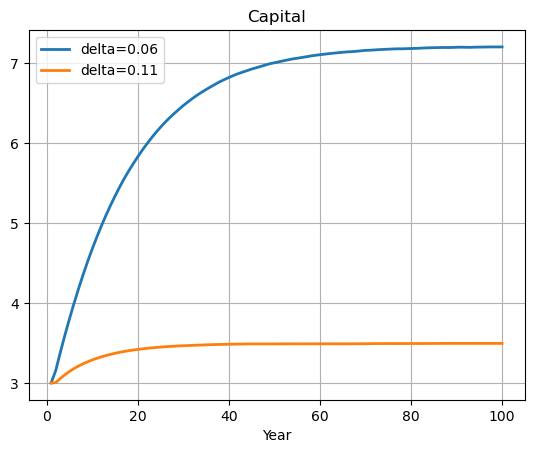

In [24]:
# TODO: Your code here.
# Example skeleton:
# p_hi = og.Params(); p_hi.delta = 0.11
# sim_hi = og.run_optimal_policy(og.init_states(p_hi), np.arange(1, p_hi.nT, dtype=int), p_hi, (0,1), [p_hi.i_s])
# Plot comparisons vs. baseline.
pass

# Initialize states and simulate with the planner
p_hi  = og.Params()
p_hi.delta=0.11
sim_hi = og.init_states(p_hi)
sim_opt_hi = og.run_optimal_policy(sim_hi.copy(), timevec, p_hi, bounds, control_id)
plt.figure()
plt.plot(years, sim_opt[:, p.i_K], linewidth=2, label="delta=0.06")
plt.plot(years, sim_opt_hi[:, p.i_K], linewidth=2, label="delta=0.11")
plt.title("Capital")
plt.xlabel("Year"); plt.grid(True); plt.legend()
plt.show()


### Exercise 3 — Compare higher capital share `alpha`
- Increase `alpha` from 0.30 to 0.45.
- Discuss how it changes the optimal savings and capital accumulation.

Optimizing: 100%|██████████| 99/99 [00:08<00:00, 11.63it/s]


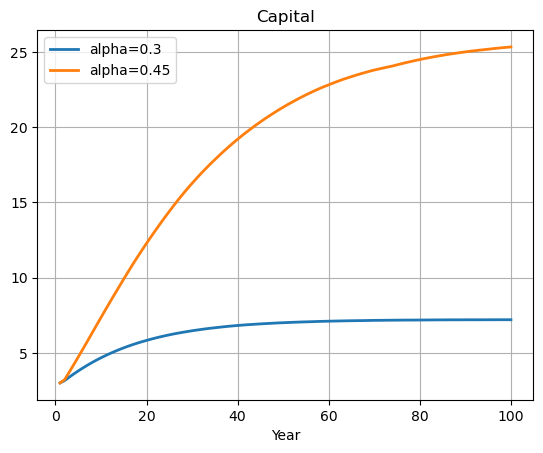

In [30]:
# TODO: Your code here.
pass


# Initialize states and simulate with the planner
p_alf  = og.Params()
p_alf.alpha =0.45
sim_alf = og.init_states(p_alf)
sim_opt_alf = og.run_optimal_policy(sim_alf.copy(), timevec, p_alf, bounds, control_id)
plt.figure()
plt.plot(years, sim_opt[:, p.i_K], linewidth=2, label="alpha=0.3")
plt.plot(years, sim_opt_alf[:, p.i_K], linewidth=2, label="alpha=0.45")
plt.title("Capital")
plt.xlabel("Year"); plt.grid(True); plt.legend()
plt.show()

### Exercise 4 — Add a DICE-style population growth law

So far, we have treated population as an exogenous flat path ($L_t = 1$).  
In integrated assessment models, population follows a **law of motion** that captures the idea of demographic saturation:

$$
L_{t+1} = L_t^{1-\zeta_L} \cdot L_{\infty}^{\zeta_L} ,
$$

- $L_{\infty}$ is the **long-run population level** (carrying capacity),  
- $\zeta_L$ controls the **speed of convergence** toward $L_{\infty}$,  

Questions
- The calibration of $\zeta_L$ is right now 0, calibrate it to 0.02.
- Compare results with stable population.

In [ ]:
# TODO: Your code here.
# You can copy and adapt og.init_states into a new function, then use it in place of the default.
#p.L0   = 1.0           # initial population (scale arbitrary)
#p.Linf = 10500         # Asymptotic population (millions)
#p.lg   = 0             # Population growth rate parameter
pass

#### Interpret your results: does a growing population increase saving? Why? 

> ✍️ You written answer here.

### Exercise 5 — Add DICE-style **TFP** dynamics with declining growth

So far, we kept productivity flat (effectively $A_t \equiv 1$ because `gA = 0`).  
We now introduce **time-varying TFP growth** that declines over time—akin to what DICE uses.

**Law of motion (implemented in `OptimalGrowth.py`):**
$$
A_t \;=\; A_{t-1}\; G_t, 
\qquad\text{with}\qquad 
G_t \;=\; \frac{1}{\,1 - g_A \exp\!\big(-\delta_A\,\Delta\,(t-1)\big)\,}\,.
$$

Equivalently, the **instantaneous growth rate** is approximately
$$
g_{A,t} \;\approx\; g_A \exp\!\big(-\delta_A\,\Delta\,(t-1)\big).
$$
Hence, **initial growth** is about $g_A$, then it **decays at rate** $\delta_A$ toward zero.

**Parameters in `Params`:**
- `A0` — initial TFP level (default $A_0 = 1$; normalization).
- `gA` — **initial** TFP growth *per year* (currently set to `0.015*0`, i.e., **zero** in the notebook).
- `deltaA` — **decay rate** of the TFP growth (per year).
- `Delta` — time step (years per period).

---

#### Suggested calibration for this exercise

Use a positive but realistic initial growth, and a slow decay:

- $A_0 = 1$
- $g_A = 0.015$  (≈ **1.5%/year** initial TFP growth)
- $\delta_A = 0.005$  (growth decays at **0.5%/year** toward zero)

**Questions / Tasks**

1. Implement the law of motion above (already in the module) by setting the parameters accordingly.
2. Re-simulate the planner’s problem and **plot $A_t$** and **compare**:
   - saving rate $s_t$,
   - output $Y_t$,
   - consumption per capita $c_t = C_t/L_t$,
   against the baseline with constant TFP.


In [ ]:
# 1) Set parameters for TFP growth that declines over time
p_tfp = og.Params()
p_tfp.A0     = 1.0
p_tfp.gA     = 0.015     # ≈ 1.5%/year initial TFP growth
p_tfp.deltaA = 0.005     # growth decay rate per year (toward 0)

#....
pass

3. Discuss: how does transitional TFP growth alter the optimal saving path and welfare relative to flat TFP?

> ✍️ You written answer here.